In [49]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve

from feature_engine.datetime import DatetimeFeatures
import joblib

### Display Settings

In [3]:
pd.set_option("display.max_columns", None)
sklearn.set_config(transform_output="pandas")

### Get Data

In [12]:
train_df = pd.read_csv("../data/train.csv")
test_df = pd.read_csv("../data/test.csv")
val_df = pd.read_csv("../data/val.csv")

In [20]:
train_df

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-06-21,Mumbai,Hyderabad,10:20:00,11:50:00,90,0.0,In-flight meal not included,4995
1,Air India,2019-05-18,Delhi,Cochin,09:00:00,07:40:00,1360,1.0,No Info,8372
2,Air India,2019-06-12,Kolkata,Banglore,09:10:00,11:05:00,1555,2.0,No Info,6117
3,Vistara,2019-04-01,Kolkata,Banglore,20:20:00,22:55:00,1595,1.0,No Info,7770
4,Vistara,2019-06-06,Kolkata,Banglore,17:00:00,10:45:00,1065,1.0,No Info,9187
...,...,...,...,...,...,...,...,...,...,...
635,Air Asia,2019-04-12,Banglore,Delhi,04:55:00,07:45:00,170,0.0,No Info,4282
636,Jet Airways,2019-05-09,Kolkata,Banglore,09:35:00,21:05:00,690,1.0,No Info,13067
637,Indigo,2019-05-15,Banglore,Delhi,06:05:00,08:50:00,165,0.0,No Info,4423
638,Multiple Carriers,2019-05-15,Delhi,Cochin,08:45:00,21:00:00,735,1.0,No Info,7670


### Split the Data

In [13]:
def split_data(df):
    X, y = df.iloc[:, :-1], df.iloc[:, -1]
    return (X,y)

In [14]:
X_train, y_train = split_data(train_df)
X_val, y_val = split_data(val_df)
X_test, y_test = split_data(test_df)

In [17]:
print(X_train.shape,X_val.shape,X_test.shape)

(640, 9) (160, 9) (200, 9)


In [18]:
print(y_train.shape,y_val.shape,y_test.shape)

(640,) (160,) (200,)


### Meta Info

In [19]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 45.1+ KB


### Data preprocessing

In [36]:
dt_cols = ["date_of_journey", "dep_time", "arrival_time"]
num_cols = ["duration", "total_stops"]
cat_cols = [col for col in X_train.columns if col not in dt_cols and col not in num_cols]

In [37]:
cat_cols

['airline', 'source', 'destination', 'additional_info']

In [98]:
num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

doj_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("extractor", DatetimeFeatures(features_to_extract=["month", "week", "day_of_week", "day_of_month"], format="mixed")),
    ("scaler", StandardScaler())
])

time_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("extractor", DatetimeFeatures(features_to_extract=["hour", "minute"], format="mixed")),
    ("scaler", StandardScaler())
])

In [99]:
preprocessor = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols),
    ("doj", doj_pipe, ["date_of_journey"]),
    ("time", time_pipe, ["dep_time", "arrival_time"])
])

In [100]:
preprocessor.fit_transform(X_data)

,num__duration,num__total_stops,cat__airline_Air Asia,cat__airline_Air India,cat__airline_Goair,cat__airline_Indigo,cat__airline_Jet Airways,cat__airline_Multiple Carriers,cat__airline_Spicejet,cat__airline_Vistara,cat__source_Banglore,cat__source_Chennai,cat__source_Delhi,cat__source_Kolkata,cat__source_Mumbai,cat__destination_Banglore,cat__destination_Cochin,cat__destination_Delhi,cat__destination_Hyderabad,cat__destination_Kolkata,cat__destination_New Delhi,cat__additional_info_1 Long layover,cat__additional_info_In-flight meal not included,cat__additional_info_No Info,cat__additional_info_No check-in baggage included,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_month,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute
0,-1.096409,-1.223551,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.126050,1.296492,0.543321,0.929387,-0.456180,-0.168288,-0.331785,1.499798
1,1.459581,0.305888,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.283356,0.346681,1.033351,0.573698,-0.631887,-1.256209,-0.915784,0.897621
2,1.852036,1.835326,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.126050,1.106529,-0.436739,-0.137682,-0.631887,-0.712248,-0.331785,-1.210000
3,1.932539,0.305888,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.559338,-0.793092,-1.416799,-1.441877,1.300892,-0.168288,1.274213,1.800887
4,0.865867,0.305888,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.126050,0.916567,0.053291,-0.849061,0.773771,-1.256209,-0.477784,1.198710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-0.734143,0.305888,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.559338,-0.793092,-0.436739,-1.204750,-0.807594,1.191613,-0.039785,-0.607823
796,-1.116535,-1.223551,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.402032,-1.742903,0.543321,-1.441877,-1.334716,1.191613,-0.915784,-1.210000
797,-0.220932,0.305888,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.283356,0.346681,1.033351,0.573698,-1.686130,1.463594,-0.185785,0.596532
798,1.852036,0.305888,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-1.402032,-1.742903,0.543321,-1.441877,1.652307,1.463594,-1.937782,1.198710


### Model Selection

In [101]:
algorithms = {
    "LR": LinearRegression(),
    "SVM": SVR(),
    "RF": RandomForestRegressor(n_estimators=10),
    "XGB": XGBRegressor(n_estimators=10)
}

In [102]:
data = pd.concat([train_df, val_df], axis = 0)
data = data.reset_index()

X_data, y_data = split_data(data)
print(X_data.shape, y_data.shape)

(800, 10) (800,)


In [103]:
def plot_curves(sizes, mean_scores, std_scores, label, ax):
    ax.plot(
        sizes,
        mean_scores,
        marker="o",
        label=label
    )

    ax.fill_between(
        x = sizes,
        y1 = mean_scores - std_scores,
        y2 = mean_scores + std_scores,
        alpha = 0.5
    )

In [106]:
def plot_learning_curves(name, algo, figsize=(12,4)):
    model = Pipeline(steps=[
        ("pre", preprocessor),
        ("alg", algo)
    ])

    train_size, train_scores, test_scores = learning_curve(
        estimator=model,
        X=X_data,
        y=y_data,
        cv=3,
        error_score="raise",
        scoring="r2",
        n_jobs=-1,
        random_state=42
    )

    mean_train_scores = np.mean(train_scores, axis = 1)
    std_train_scores = np.std(train_scores, axis = 1)
    train_score = f"{mean_train_scores[-1]:.2f} +/- {std_train_scores[-1]:.2f}"

    mean_test_scores = np.mean(test_scores, axis = 1)
    std_test_scores = np.std(test_scores, axis = 1)
    test_score = f"{mean_test_scores[-1]:.2f} +/- {std_test_scores[-1]:.2f}"

    fig, ax = plt.subplots(figsize=figsize)

    #training curve
    plot_curves(
        train_size,
        mean_train_scores,
        std_train_scores,
        f"Train ({train_score})",
        ax
    )
    #test curve
    plot_curves(
        train_size,
        mean_test_scores,
        std_test_scores,
        f"Test ({test_score})",
        ax
    )

    ax.set(xlabel="Training set sizes", ylabel="R2 values", title=name)
    
    ax.legend(loc="lower right")

    plt.show()

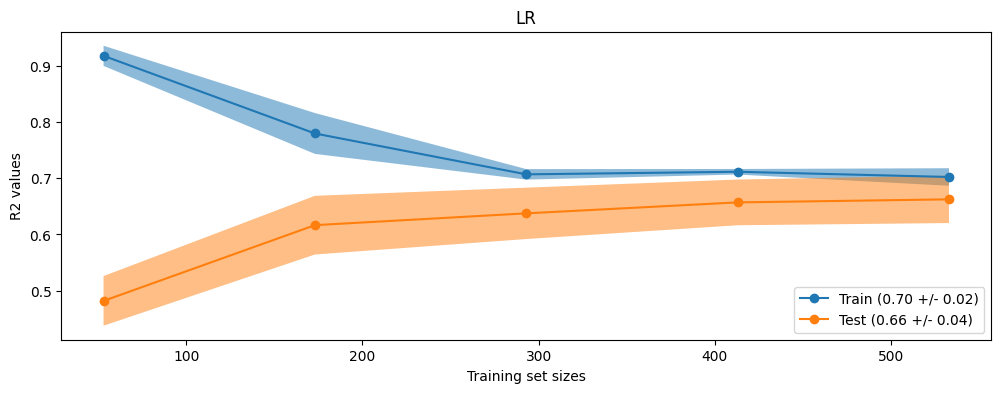

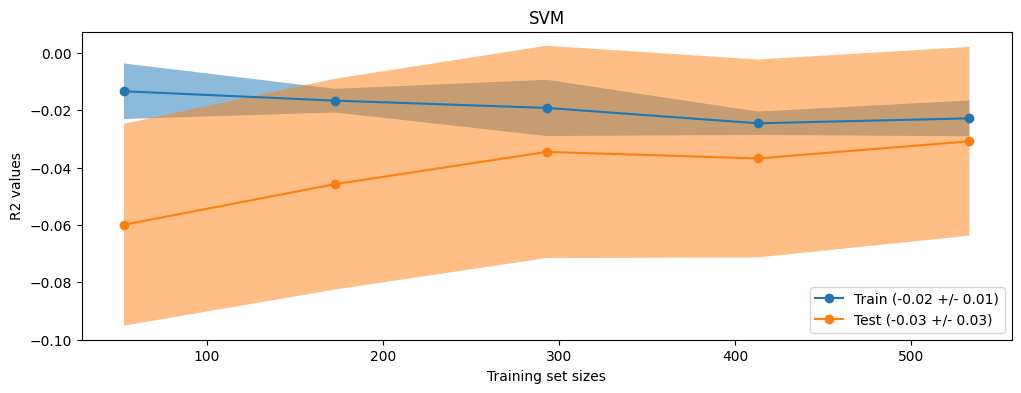

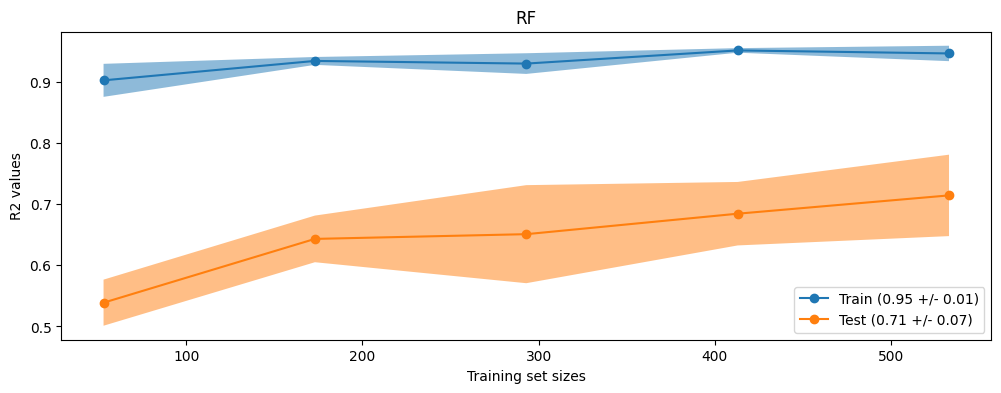

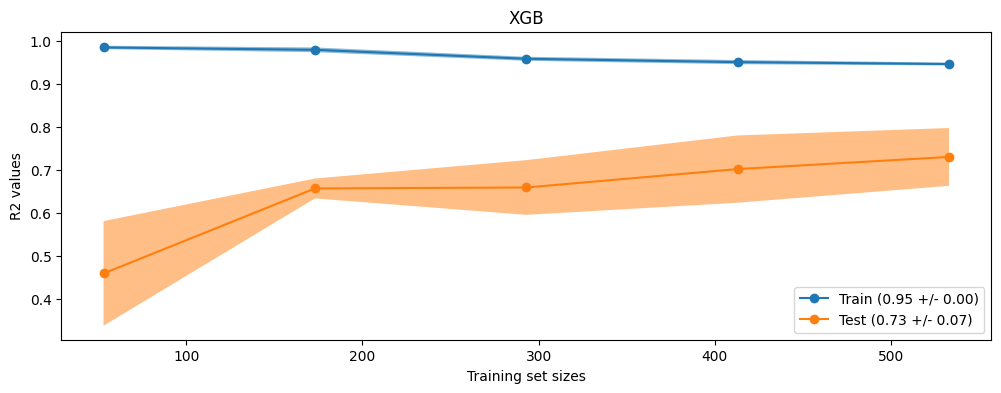

In [107]:
for name, alg in algorithms.items():
    plot_learning_curves(name, alg)

### Model Training

In [108]:
model = Pipeline(steps=[
    ("pre", preprocessor),
    ("rf", XGBRegressor(n_estimators=10))
])

In [109]:
model.fit(X_data, y_data)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=10, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

### Model Evaluation

In [110]:
def evaluate_model(X, y):
    y_pred = model.predict(X)
    return r2_score(y, y_pred)

In [111]:
print(f"R2 score on Training data = {evaluate_model(X_data, y_data)}")

R2 score on Training data = 0.9289921522140503


In [112]:
print(f"R2 score on Test data = {evaluate_model(X_test, y_test)}")

R2 score on Test data = 0.7367968559265137


### Model Persistence

In [113]:
joblib.dump(model, "model.joblib")

['model.joblib']